In [1]:
# Set up the environment
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
%matplotlib inline

In [2]:
# Upload the data
# data will contain everything, names and locations
# df will contain the features used in the modeling
data = pd.read_csv('data/processed/DecisionTreeData.csv', index_col=0)
data = data.loc[data.PREDDEG == 3]
data.sort_index(inplace=True)
data.head()

,OPEID,INSTNM,CITY,NUMBRANCH,PREDDEG,HIGHDEG,CONTROL,region,ADM_RATE,UGDS,...,Year,NetPrice,Cost,EnrollmentBins,TuitionBins,ExpenditureBins,FacultyBins,Complete,RetentionFT,RetentionPT
0,00100200,alabama a & m university,NORMAL,1,3,4,1.0,5.0,0.4457,5292.0,...,2003,7966.0,13242.0,xl,med,med,med,0.3802,0.8048,NaN
1,00105200,university of alabama at birmingham,BIRMINGHAM,1,3,4,1.0,5.0,0.8049,10381.0,...,2003,12399.0,16955.0,xl,med,highest,high,0.3857,0.8048,NaN
2,02503400,southern christian university,MONTGOMERY,1,3,4,2.0,5.0,NaN,336.0,...,2003,19265.0,32895.0,medium,high,med,low,0.5455,0.8255,NaN
3,00105500,university of alabama in huntsville,HUNTSVILLE,1,3,4,1.0,5.0,0.8756,4966.0,...,2003,10044.0,16876.0,xl,med,med,high,0.4369,0.8048,NaN
4,00100500,alabama state university,MONTGOMERY,1,3,4,1.0,5.0,0.5042,4941.0,...,2003,8904.0,14000.0,xl,med,med,med,0.2117,0.8048,NaN


In [3]:
# Separate open and closed schoools
closed = data.loc[(data.CURROPER == False) & (data.Year > 2009)]
closed.shape

(241, 31)

In [4]:
open_df = data.loc[(data.CURROPER==True) & (data.Year > 2009)]
open_df.shape

(8140, 31)

In [5]:
current = open_df.loc[data.Year > 2012]
current.shape

(2100, 31)

In [6]:
data = pd.concat([current, closed], axis = 0)
data.shape

(2341, 31)

In [7]:
#df contains just the feature to train the model on
to_drop = ['OPEID', 'INSTNM', 'CITY', 'HIGHDEG', 'ADM_RATE', 'NetPrice', 'region','EnrollmentBins',\
           'TuitionBins','ExpenditureBins','FacultyBins', 'AVGFACSAL', 'RetentionPT', 'PCTFLOAN', 'Year']
df = data.drop(to_drop, axis=1)
df.head()

,NUMBRANCH,PREDDEG,CONTROL,UGDS,CURROPER,TUITFTE,INEXPFTE,PFTFAC,UG25abv,COMP_ORIG_YR4_RT,WDRAW_ORIG_YR4_RT,ENRL_ORIG_YR4_RT,DEBT_MDN,Cost,Complete,RetentionFT
70813,1,3,1.0,4051.0,True,9063.0,7459.0,0.8856,0.1049,0.256983,0.228252,0.150838,19500.0,18888.0,0.2914,0.6314
70814,1,3,1.0,11200.0,True,9033.0,17208.0,0.9106,0.2422,0.445502,0.184674,0.113279,16250.0,19990.0,0.5377,0.8016
70815,1,3,2.0,322.0,True,12057.0,5123.0,0.6721,0.8540,0.288591,0.382550,0.041270,10500.0,12300.0,0.6667,0.3750
70816,1,3,1.0,5525.0,True,8322.0,9352.0,0.6555,0.2640,0.377617,0.149758,0.116747,16500.0,20306.0,0.4835,0.8098
70817,1,3,1.0,5354.0,True,7813.0,7393.0,0.6641,0.1270,0.183563,0.256749,0.109778,15854.5,17400.0,0.2517,0.6219


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2341 entries, 70813 to 78179
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   NUMBRANCH          2341 non-null   int64  
 1   PREDDEG            2341 non-null   int64  
 2   CONTROL            2341 non-null   float64
 3   UGDS               2341 non-null   float64
 4   CURROPER           2341 non-null   bool   
 5   TUITFTE            2341 non-null   float64
 6   INEXPFTE           2341 non-null   float64
 7   PFTFAC             2341 non-null   float64
 8   UG25abv            2341 non-null   float64
 9   COMP_ORIG_YR4_RT   2341 non-null   float64
 10  WDRAW_ORIG_YR4_RT  2341 non-null   float64
 11  ENRL_ORIG_YR4_RT   2341 non-null   float64
 12  DEBT_MDN           2341 non-null   float64
 13  Cost               2341 non-null   float64
 14  Complete           2341 non-null   float64
 15  RetentionFT        2341 non-null   float64
dtypes: bool(1), float64

In [9]:
y = df.CURROPER
X = df.drop('CURROPER', axis=1)

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=21, stratify=y)

In [11]:
X_test.shape

(703, 15)

# Decision Tree Model
Basis for comparison

In [12]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier

## Explore just the criterion and max_depth features

Code modified from https://towardsdatascience.com/decision-tree-build-prune-and-visualize-it-using-python-12ceee9af752

In [13]:
from sklearn import metrics
max_depth = []
acc_gini = []
acc_entropy = []
for i in range(1, 31):
    gtree = DecisionTreeClassifier(criterion='gini', max_depth=i, random_state=21)
    gtree.fit(X_train, y_train)
    gpredict = gtree.predict(X_test)
    acc_gini.append(metrics.accuracy_score(y_test, gpredict))
    ##
    etree = DecisionTreeClassifier(criterion='entropy', max_depth=i, random_state=21)
    etree.fit(X_train, y_train)
    epredict = etree.predict(X_test)
    acc_entropy.append(metrics.accuracy_score(y_test, epredict))
    ##
    max_depth.append(i)

In [14]:
gini_max = max(acc_gini)
gini_idx = acc_gini.index(gini_max)
entropy_max = max(acc_entropy)
entropy_idx = acc_entropy.index(entropy_max)

if gini_max > entropy_max:
    depth = max_depth[gini_idx]
else:
    depth = max_depth[entropy_idx] 
    
print(depth)

5


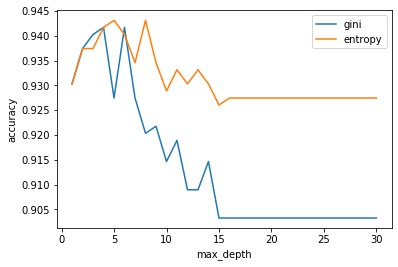

In [15]:
trees = pd.DataFrame({'acc_gini':pd.Series(acc_gini),
                     'acc_entropy':pd.Series(acc_entropy),
                     'max_depth':pd.Series(max_depth)})

plt.plot('max_depth', 'acc_gini', data=trees, label='gini')
plt.plot('max_depth', 'acc_entropy', data=trees, label='entropy')
#plt.vlines(6, 0.895, 0.915)
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [16]:
# Train the decision tree using the identified hyperparameters
modelDT = DecisionTreeClassifier(criterion='gini', max_depth=depth, random_state=21)
modelDT.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=21, splitter='best')

In [17]:
# Use the trained tree to predict the testing data
dt_pred = modelDT.predict(X_test)
dt_pred_prob = modelDT.predict(X_test)

In [18]:
# Run this block for model evaluation 
#from sklearn import metrics
print("Model Metrics")
print("Accuracy:", metrics.accuracy_score(y_test, dt_pred))
print("Balanced accuracy:", metrics.balanced_accuracy_score(y_test, dt_pred))
print('Precision score for "Yes"' , metrics.precision_score(y_test, dt_pred, pos_label = 1))
print('Recall score for "No"' , metrics.recall_score(y_test, dt_pred, pos_label = 0))

Model Metrics
Accuracy: 0.9274537695590327
Balanced accuracy: 0.7442661560133826
Precision score for "Yes" 0.9461538461538461
Recall score for "No" 0.5138888888888888


In [19]:
from sklearn.metrics import confusion_matrix, classification_report
print(confusion_matrix(y_test, dt_pred))

[[ 37  35]
 [ 16 615]]


In [20]:
print(classification_report(y_test, dt_pred))

              precision    recall  f1-score   support

       False       0.70      0.51      0.59        72
        True       0.95      0.97      0.96       631

    accuracy                           0.93       703
   macro avg       0.82      0.74      0.78       703
weighted avg       0.92      0.93      0.92       703



In [21]:
importances = modelDT.feature_importances_
#std = np.std([tree.feature_importances_ for tree in modelDF.],axis=0)
indices = np.argsort(importances)[::-1]
names = [X_train.columns[i] for i in indices]

print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, names[f], importances[indices[f]]))

Feature ranking:
1. feature NUMBRANCH (0.595845)
2. feature UGDS (0.132983)
3. feature TUITFTE (0.050752)
4. feature Complete (0.041603)
5. feature WDRAW_ORIG_YR4_RT (0.037102)
6. feature INEXPFTE (0.030214)
7. feature RetentionFT (0.024949)
8. feature COMP_ORIG_YR4_RT (0.024347)
9. feature Cost (0.024109)
10. feature ENRL_ORIG_YR4_RT (0.022364)
11. feature UG25abv (0.015733)
12. feature DEBT_MDN (0.000000)
13. feature PFTFAC (0.000000)
14. feature CONTROL (0.000000)
15. feature PREDDEG (0.000000)


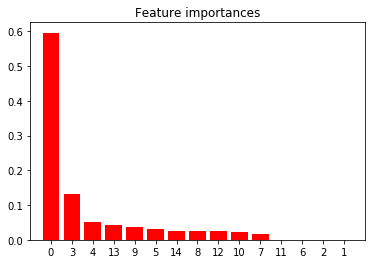

In [22]:
# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
        color="r",  align="center") #yerr=std[indices],
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

'One' predicts currently open schools. So having more branches is an indicator of being open. The more branches you have, the more likely you are to be open. 

Is it the case that not having many branches leads to closing?

Having high enrollment rates predicts being open - more enrollment = more chance of being open

Other features ar really small.

## AdaBoost model

In [23]:
ABmax_depth = []
score_a = []
score_b = []

for i in range(105, 131, 1):
    atree = AdaBoostClassifier(n_estimators=i, random_state=21)
    atree.fit(X_train, y_train)
    apredict = gtree.predict(X_test)
    score_a.append(metrics.accuracy_score(y_test, apredict))
    ##
    btree = AdaBoostClassifier(modelDT, n_estimators=i, random_state=21)
    btree.fit(X_train, y_train)
    bpredict = btree.predict(X_test)
    score_b.append(metrics.accuracy_score(y_test, bpredict))
    ##
    ABmax_depth.append(i)

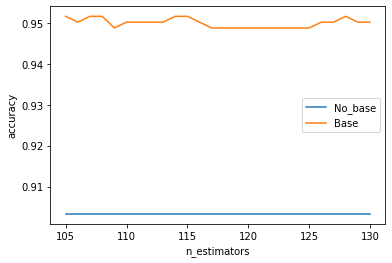

In [24]:
adatrees = pd.DataFrame({'score_a':pd.Series(score_a),
                     'score_b':pd.Series(score_b),
                     'n_estimators':pd.Series(ABmax_depth)})

plt.plot('n_estimators', 'score_a', data=adatrees, label='No_base')
plt.plot('n_estimators', 'score_b', data=adatrees, label='Base')
#plt.vlines(6, 0.895, 0.915)
plt.xlabel('n_estimators')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [25]:
ideal_estimators = max(score_b)
idx = score_b.index(ideal_estimators)
print(ABmax_depth[idx])

105


In [26]:
modelAB = AdaBoostClassifier(modelDT, n_estimators=ABmax_depth[idx], random_state=21)
modelAB.fit(X_train, y_train)
AB_pred = modelAB.predict(X_test)
print(metrics.accuracy_score(y_test, AB_pred))

0.9516358463726885


In [27]:
print(confusion_matrix(y_test, AB_pred))

[[ 47  25]
 [  9 622]]


In [28]:
print(classification_report(y_test, AB_pred))

              precision    recall  f1-score   support

       False       0.84      0.65      0.73        72
        True       0.96      0.99      0.97       631

    accuracy                           0.95       703
   macro avg       0.90      0.82      0.85       703
weighted avg       0.95      0.95      0.95       703



In [29]:
importances = modelAB.feature_importances_
std = np.std([tree.feature_importances_ for tree in modelAB.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
names = [X_train.columns[i] for i in indices]

print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, names[f], importances[indices[f]]))

Feature ranking:
1. feature TUITFTE (0.112988)
2. feature UGDS (0.108724)
3. feature PFTFAC (0.090840)
4. feature Cost (0.085563)
5. feature ENRL_ORIG_YR4_RT (0.084734)
6. feature RetentionFT (0.082828)
7. feature UG25abv (0.082681)
8. feature INEXPFTE (0.076468)
9. feature Complete (0.071033)
10. feature DEBT_MDN (0.066266)
11. feature WDRAW_ORIG_YR4_RT (0.059782)
12. feature COMP_ORIG_YR4_RT (0.052813)
13. feature NUMBRANCH (0.022896)
14. feature CONTROL (0.002385)
15. feature PREDDEG (0.000000)


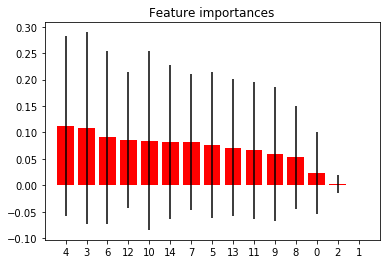

In [30]:
# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

## Exploration of misclassified schools

We are interested in predicting schools that might be in danger of closing. This would be schools that are currently open, but that the model predicts are closed. (These would be the "false negative" cases.) There are 9 schools in this class that could be explored further.

In [31]:
result_dict = {'CURROPER':y_test, 'Predicted':AB_pred}
results = pd.DataFrame(result_dict)
results.head()

,CURROPER,Predicted
56310,False,False
65405,False,False
72759,True,True
74761,True,True
73563,True,True


In [63]:
predicted = pd.concat([X_test, results], axis=1)
predicted.head()

,NUMBRANCH,PREDDEG,CONTROL,UGDS,TUITFTE,INEXPFTE,PFTFAC,UG25abv,COMP_ORIG_YR4_RT,WDRAW_ORIG_YR4_RT,ENRL_ORIG_YR4_RT,DEBT_MDN,Cost,Complete,RetentionFT,CURROPER,Predicted
56310,1,3,1.0,5523.0,2453.0,4617.0,1.0000,0.4270,0.152676,0.180282,0.109296,10500.0,10335.0,0.1273,0.7432,False,False
65405,1,3,1.0,974.0,21881.0,36361.0,0.3633,0.7597,0.724719,0.117978,0.000000,12500.0,16979.0,0.4495,0.8048,False,False
72759,10,3,3.0,896.0,20086.0,4650.0,0.1750,0.7117,0.365833,0.343687,0.021858,21905.0,30125.0,0.3333,0.6154,True,True
74761,1,3,2.0,810.0,16798.0,10877.0,0.5444,0.3924,0.564394,0.159091,0.034161,21000.0,31688.0,0.3974,0.6111,True,True
73563,1,3,2.0,1393.0,9187.0,5825.0,0.5986,0.1466,0.422872,0.177711,0.041270,12000.0,36669.0,0.3818,0.5826,True,True


In [64]:
false_pos = predicted.loc[(predicted.Predicted == True) & (predicted.CURROPER == False)]
false_pos.shape

(25, 17)

In [65]:
false_neg = predicted.loc[(predicted.Predicted==False) & (predicted.CURROPER==True)]
false_neg.shape

(9, 17)

In [66]:
false_neg.head(9)
#false_neg.index

,NUMBRANCH,PREDDEG,CONTROL,UGDS,TUITFTE,INEXPFTE,PFTFAC,UG25abv,COMP_ORIG_YR4_RT,WDRAW_ORIG_YR4_RT,ENRL_ORIG_YR4_RT,DEBT_MDN,Cost,Complete,RetentionFT,CURROPER,Predicted
70843,1,3,2.0,331.0,7626.0,9293.0,1.0000,0.2622,0.125000,0.401786,0.041270,14250.0,27815.0,0.4051,0.5974,True,False
77090,99,3,3.0,578.0,15744.0,2171.0,0.2182,0.8397,0.112562,0.486724,0.052962,12500.0,32554.0,0.2629,0.3333,True,False
76945,99,3,3.0,389.0,16887.0,1860.0,0.1081,0.8590,0.112562,0.486724,0.052962,12500.0,32554.0,0.2629,1.0000,True,False
76324,31,3,3.0,150.0,7459.0,852.0,0.1507,0.7021,0.134772,0.373141,0.074580,10490.5,28115.0,0.0000,0.3333,True,False
77832,71,3,3.0,85.0,9531.0,2167.0,0.1507,0.8941,0.188030,0.464499,0.038686,18532.0,23434.0,0.2629,0.2667,True,False
76408,71,3,3.0,1350.0,12374.0,2042.0,0.0781,0.8956,0.188030,0.464499,0.038686,18532.0,22715.0,0.1598,0.5481,True,False
76600,1,3,2.0,1624.0,2852.0,1732.0,0.0435,0.2912,0.422872,0.177711,0.041270,12580.0,32895.0,0.5455,0.8255,True,False
73973,1,3,1.0,832.0,22558.0,62925.0,0.5578,0.7813,0.909707,0.022573,0.000000,12661.5,16979.0,0.4495,0.8048,True,False
71874,1,3,2.0,458.0,4231.0,7564.0,0.2963,0.0288,0.047619,0.177711,0.000000,5500.0,33966.0,0.0484,0.2182,True,False


In [67]:
false_neg_names = false_neg.join(data, how = 'left', lsuffix='_FN')
false_neg_names['INSTNM']

70843                                       judson college
77090                        strayer university-new jersey
76945                           strayer university-alabama
76324    national american university-ellsworth afb ext...
77832               university of phoenix-lafayette campus
76408                 university of phoenix-atlanta campus
76600    central methodist university-college of gradua...
73973                   oregon health & science university
71874                           hebrew theological college
Name: INSTNM, dtype: object

## Generate graphs for the report

In [68]:
predicted['Result'] = np.nan
predicted.loc[(predicted.Predicted==True)&(predicted.CURROPER==True), 'Result'] = 'TP'
predicted.loc[(predicted.Predicted==False)&(predicted.CURROPER==False), 'Result'] = 'TN'
predicted.loc[(predicted.Predicted==True)&(predicted.CURROPER==False), 'Result'] = 'FP'
predicted.loc[(predicted.Predicted==False)&(predicted.CURROPER==True), 'Result'] = 'FN'
#print(predicted.Result)

In [69]:
to_graph = pd.merge(predicted, data)
to_graph.head()

,NUMBRANCH,PREDDEG,CONTROL,UGDS,TUITFTE,INEXPFTE,PFTFAC,UG25abv,COMP_ORIG_YR4_RT,WDRAW_ORIG_YR4_RT,...,ADM_RATE,AVGFACSAL,PCTFLOAN,Year,NetPrice,EnrollmentBins,TuitionBins,ExpenditureBins,FacultyBins,RetentionPT
0,1,3,1.0,5523.0,2453.0,4617.0,1.0000,0.4270,0.152676,0.180282,...,0.7532,5511.0,0.3875,2011,4976.0,xl,low,med,med,0.6111
1,1,3,1.0,974.0,21881.0,36361.0,0.3633,0.7597,0.724719,0.117978,...,NaN,9000.0,0.4569,2012,12064.0,large,highest,highest,highest,NaN
2,10,3,3.0,896.0,20086.0,4650.0,0.1750,0.7117,0.365833,0.343687,...,NaN,4757.0,0.7315,2013,22545.0,large,highest,med,med,0.7500
3,1,3,2.0,810.0,16798.0,10877.0,0.5444,0.3924,0.564394,0.159091,...,0.4106,6610.0,0.7529,2013,22092.0,large,highest,highest,high,NaN
4,1,3,2.0,1393.0,9187.0,5825.0,0.5986,0.1466,0.422872,0.177711,...,0.6447,5017.0,0.8905,2013,16626.0,large,high,med,med,0.0000


In [70]:
to_graph.CONTROL = to_graph.CONTROL.astype('str')
to_graph.CONTROL.loc[to_graph.CONTROL == '1.0'] = 'Public'
to_graph.CONTROL.loc[to_graph.CONTROL == '2.0'] = 'NonProfit'
to_graph.CONTROL.loc[to_graph.CONTROL == '3.0'] = 'ForProfit'

to_graph.PREDDEG = to_graph.PREDDEG.astype('str')
#to_graph.drop(['EnrollmentBins', 'TuitionBins', 'ExpenditureBins', 'FacultyBins'], axis=1, inplace=True)
to_graph.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 703 entries, 0 to 702
Data columns (total 33 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   NUMBRANCH          703 non-null    int64  
 1   PREDDEG            703 non-null    object 
 2   CONTROL            703 non-null    object 
 3   UGDS               703 non-null    float64
 4   TUITFTE            703 non-null    float64
 5   INEXPFTE           703 non-null    float64
 6   PFTFAC             703 non-null    float64
 7   UG25abv            703 non-null    float64
 8   COMP_ORIG_YR4_RT   703 non-null    float64
 9   WDRAW_ORIG_YR4_RT  703 non-null    float64
 10  ENRL_ORIG_YR4_RT   703 non-null    float64
 11  DEBT_MDN           703 non-null    float64
 12  Cost               703 non-null    float64
 13  Complete           703 non-null    float64
 14  RetentionFT        703 non-null    float64
 15  CURROPER           703 non-null    bool   
 16  Predicted          703 non

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [71]:
predControl = to_graph.pivot_table(index='PREDDEG', columns=['CONTROL','Result'], aggfunc='size')
print(predControl)

CONTROL ForProfit            NonProfit             Public           
Result         FN FP  TN  TP        FN  FP TN   TP     FN FP TN   TP
PREDDEG                                                             
3               5  8  36  72         3  15  9  366      1  2  2  184


In [72]:
false_neg = to_graph.loc[to_graph.Result == 'FN']
false_neg.head()

,NUMBRANCH,PREDDEG,CONTROL,UGDS,TUITFTE,INEXPFTE,PFTFAC,UG25abv,COMP_ORIG_YR4_RT,WDRAW_ORIG_YR4_RT,...,ADM_RATE,AVGFACSAL,PCTFLOAN,Year,NetPrice,EnrollmentBins,TuitionBins,ExpenditureBins,FacultyBins,RetentionPT
195,1,3,NonProfit,331.0,7626.0,9293.0,1.0000,0.2622,0.125000,0.401786,...,0.7388,5638.0,0.7110,2013,17243.0,medium,high,high,med,NaN
238,99,3,ForProfit,578.0,15744.0,2171.0,0.2182,0.8397,0.112562,0.486724,...,NaN,6549.0,0.7123,2013,31487.0,large,highest,low,high,0.2157
262,99,3,ForProfit,389.0,16887.0,1860.0,0.1081,0.8590,0.112562,0.486724,...,NaN,6356.0,0.8593,2013,29771.0,medium,highest,low,high,0.2000
351,31,3,ForProfit,150.0,7459.0,852.0,0.1507,0.7021,0.134772,0.373141,...,NaN,NaN,0.0763,2013,23000.0,small,high,low,NaN,0.2500
372,71,3,ForProfit,85.0,9531.0,2167.0,0.1507,0.8941,0.188030,0.464499,...,NaN,2510.0,0.7000,2013,18356.0,small,high,low,low,NaN


## UGDS - Undergraduate enrollment

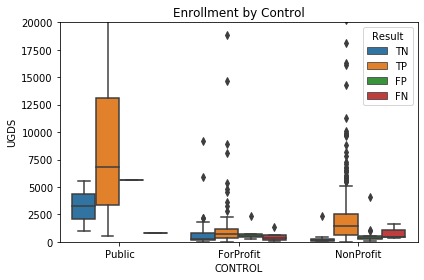

In [73]:
#fig=plt.figure(figsize=(10,4), dpi= 100, facecolor='w', edgecolor='k')
#plt.subplot(1, 2, 1)
sns.boxplot('CONTROL', 'UGDS', data = to_graph, hue = 'Result')
plt.ylim(0, 20000)
plt.title('Enrollment by Control')

# plt.subplot(1, 2, 2)
# sns.boxplot('PREDDEG', 'UGDS', data = to_graph, hue = 'Result')
# plt.ylim(0, 10000)
# plt.title('Enrollment by Degree Type')
plt.tight_layout()

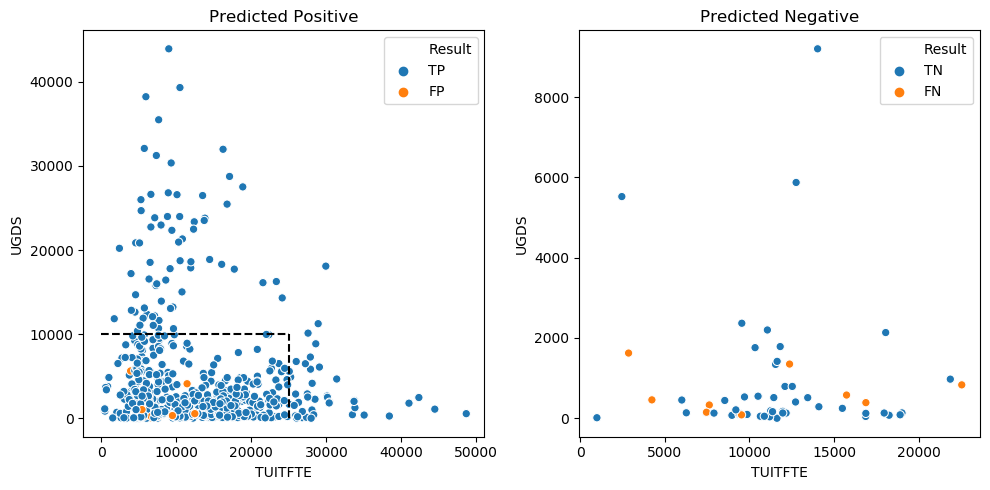

In [79]:
fig=plt.figure(figsize=(10,5), dpi= 100, facecolor='w', edgecolor='k')
plt.subplot(1, 2, 1)
sns.scatterplot('TUITFTE', 'UGDS', data=to_graph.loc[to_graph.Predicted==True], hue = 'Result')
plt.title('Predicted Positive')
plt.hlines(y=10000, xmin=0, xmax=25000, linestyles='dashed')
plt.vlines(x=25000, ymin=0, ymax=10000, linestyles='dashed')
#plt.xlim(0,20000)
#plt.ylim(0,10000)

plt.subplot(1, 2, 2)
sns.scatterplot('TUITFTE', 'UGDS', data=to_graph.loc[to_graph.Predicted==False], hue = 'Result')
plt.title('Predicted Negative')
#plt.xlim(0,100000)
#plt.ylim(0,40000)
plt.tight_layout()
plt.show()

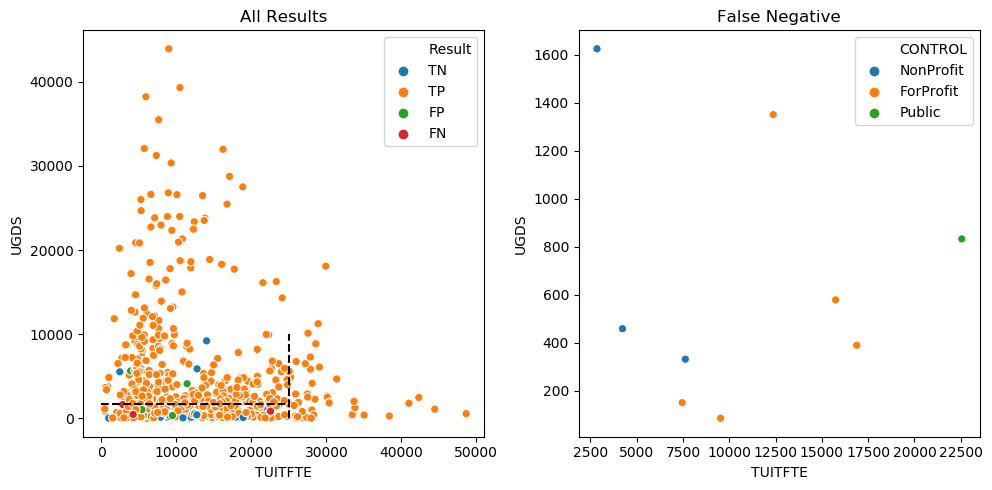

In [80]:
fig=plt.figure(figsize=(10,5), dpi= 100, facecolor='w', edgecolor='k')
plt.subplot(1, 2, 1)
sns.scatterplot('TUITFTE', 'UGDS', data=to_graph, hue = 'Result')
plt.title('All Results')

plt.subplot(1, 2, 2)
sns.scatterplot('TUITFTE', 'UGDS', data=to_graph.loc[to_graph.Result=='FN'], hue = 'CONTROL')
plt.title('False Negative')
plt.tight_layout()
plt.show()

## Tuition and Cost

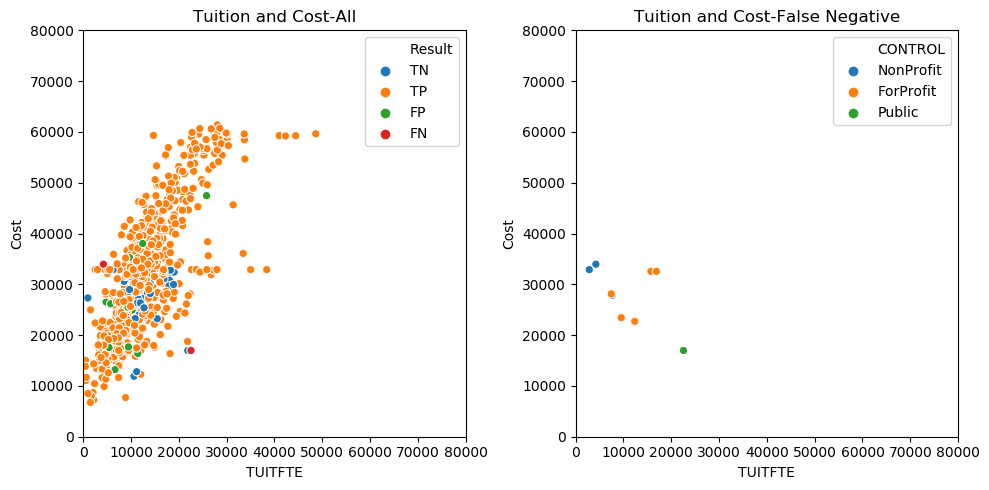

In [44]:
fig=plt.figure(figsize=(10,5), dpi= 100, facecolor='w', edgecolor='k')
plt.subplot(1, 2, 1)
sns.scatterplot('TUITFTE', 'Cost', data=to_graph, hue = 'Result')
plt.xlim(0, 80000)
plt.ylim(0, 80000)
plt.title('Tuition and Cost-All')

plt.subplot(1, 2, 2)
sns.scatterplot('TUITFTE', 'Cost', data=to_graph.loc[to_graph.Result=='FN'], hue = 'CONTROL')
plt.xlim(0, 80000)
plt.ylim(0, 80000)
plt.title('Tuition and Cost-False Negative')
plt.tight_layout()
plt.show()

## Cost and Debt

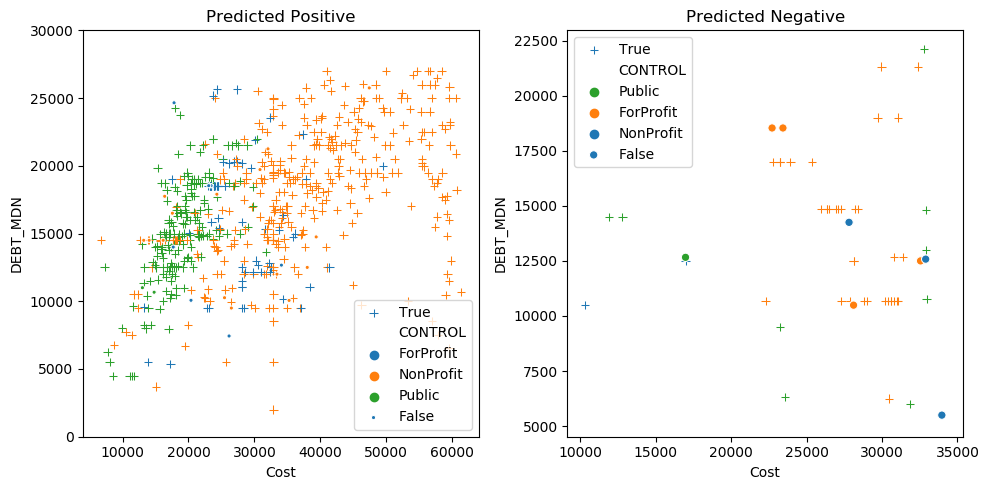

In [45]:
fig=plt.figure(figsize=(10,5), dpi= 100, facecolor='w', edgecolor='k')
plt.subplot(1, 2, 1)
#sns.scatterplot('Cost', 'DEBT_MDN', data=to_graph.loc[to_graph.Predicted==True], hue='CONTROL')
sns.scatterplot('Cost', 'DEBT_MDN', data=to_graph.loc[to_graph.Result=='TP'], hue='CONTROL', marker='+', label='True')
sns.scatterplot('Cost', 'DEBT_MDN', data=to_graph.loc[to_graph.Result=='FP'], hue='CONTROL', marker='.', label='False')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.title('Predicted Positive')
plt.ylim(0,30000)

plt.subplot(1, 2, 2)
sns.scatterplot('Cost', 'DEBT_MDN', data=to_graph.loc[to_graph.Result=='TN'], hue='CONTROL', marker='+', label='True')
sns.scatterplot('Cost', 'DEBT_MDN', data=to_graph.loc[to_graph.Result=='FN'], hue='CONTROL', marker='o', label='False')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.title('Predicted Negative')
plt.tight_layout()
plt.show()

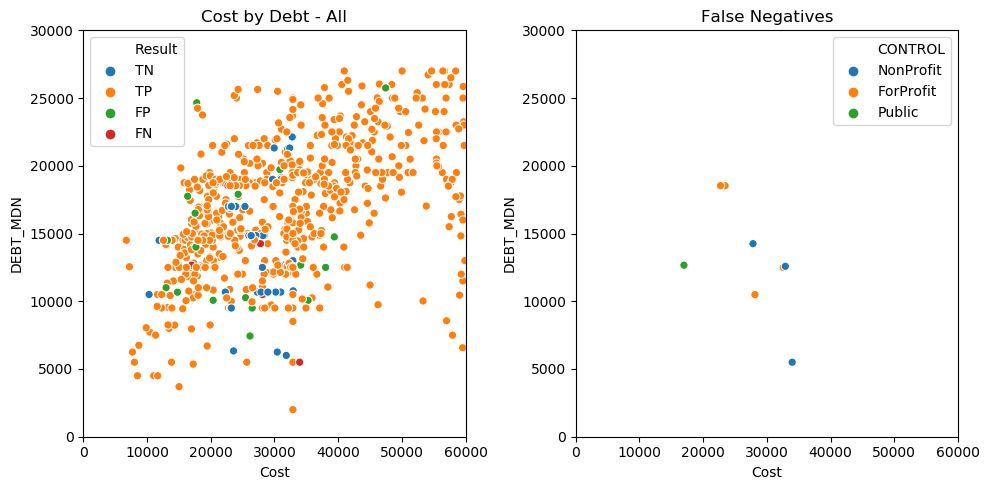

In [83]:
fig=plt.figure(figsize=(10,5), dpi= 100, facecolor='w', edgecolor='k')
plt.subplot(1, 2, 1)
sns.scatterplot('Cost', 'DEBT_MDN', data=to_graph, hue='Result')
plt.title('Cost by Debt - All')
plt.ylim(0,30000)
plt.xlim(0,60000)

plt.subplot(1, 2, 2)
sns.scatterplot('Cost', 'DEBT_MDN', data=to_graph.loc[to_graph.Result=='FN'], hue='CONTROL')
plt.title('False Negatives')
plt.ylim(0,30000)
plt.xlim(0,60000)
plt.tight_layout()
plt.show()

## NumBranch

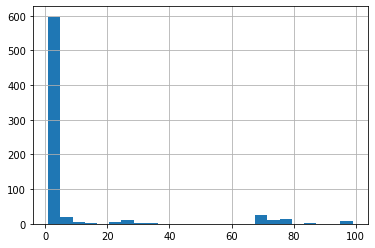

In [47]:
to_graph.NUMBRANCH.hist(bins=25)

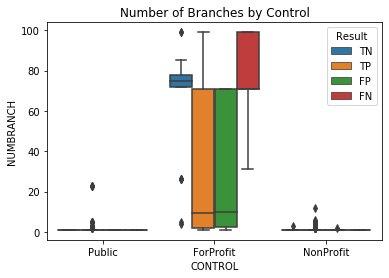

In [84]:
#fig=plt.figure(figsize=(10,4), dpi= 100, facecolor='w', edgecolor='k')
#plt.subplot(1, 2, 1)
sns.boxplot('CONTROL', 'NUMBRANCH', data = to_graph, hue = 'Result')
#plt.ylim(0, 100)
plt.title('Number of Branches by Control')

#plt.subplot(1, 2, 2)
#sns.boxplot('PREDDEG', 'NUMBRANCH', data = to_graph, hue = 'Result')
#plt.ylim(0, 100)
#plt.title('Number of Branches by Degree Type')
#plt.tight_layout()
plt.show()

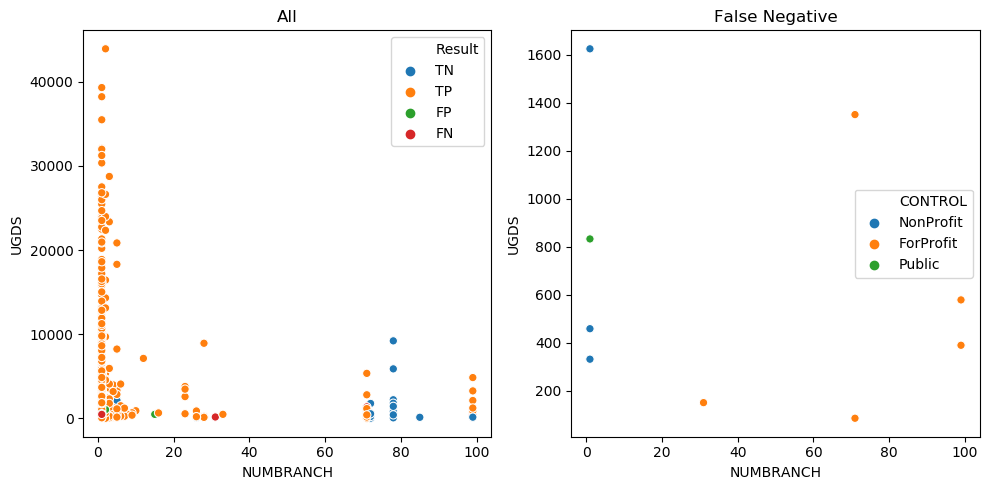

In [49]:
fig=plt.figure(figsize=(10,5), dpi= 100, facecolor='w', edgecolor='k')
plt.subplot(1, 2, 1)
sns.scatterplot('NUMBRANCH', 'UGDS', data=to_graph, hue = 'Result')
plt.title('All')

plt.subplot(1, 2, 2)
sns.scatterplot('NUMBRANCH', 'UGDS', data=to_graph.loc[to_graph.Result=='FN'], hue = 'CONTROL')
plt.title('False Negative')
plt.tight_layout()
plt.show()

## Instructional Expenditure

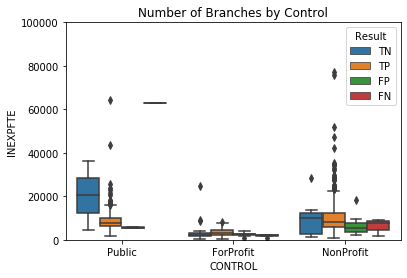

In [85]:
#fig=plt.figure(figsize=(10,4), dpi= 100, facecolor='w', edgecolor='k')
#plt.subplot(1, 2, 1)
sns.boxplot('CONTROL', 'INEXPFTE', data = to_graph, hue = 'Result')
plt.ylim(0, 100000)
plt.title('Number of Branches by Control')

# plt.subplot(1, 2, 2)
# sns.boxplot('PREDDEG', 'INEXPFTE', data = to_graph, hue = 'Result')
# plt.ylim(0, 100000)
# plt.title('Number of Branches by Degree Type')
# plt.tight_layout()
plt.show()

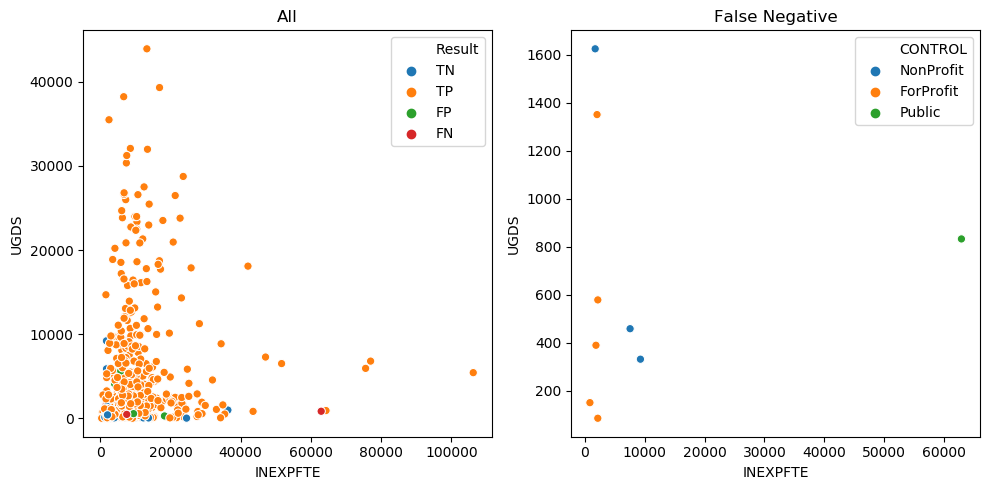

In [87]:
fig=plt.figure(figsize=(10,5), dpi= 100, facecolor='w', edgecolor='k')
plt.subplot(1, 2, 1)
sns.scatterplot('INEXPFTE', 'UGDS', data=to_graph, hue = 'Result')
#plt.xlim(0, 100000)
#plt.ylim(0, 12000)
plt.title('All Results')

plt.subplot(1, 2, 2)
sns.scatterplot('INEXPFTE', 'UGDS', data=to_graph.loc[to_graph.Result=='FN'], hue = 'CONTROL')
#plt.xlim(0, 100000)
#plt.ylim(0, 12000)
plt.title('False Negative')
plt.tight_layout()
plt.show()

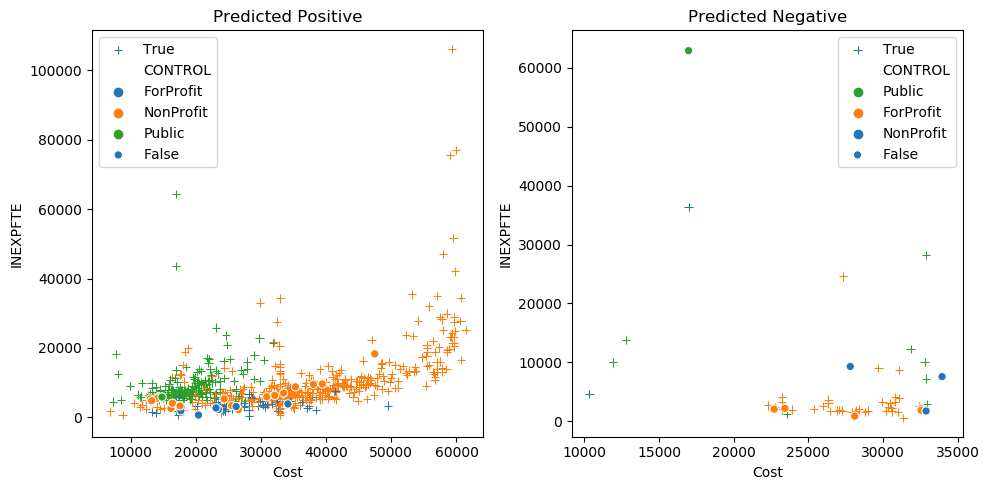

In [91]:
fig=plt.figure(figsize=(10,5), dpi= 100, facecolor='w', edgecolor='k')
plt.subplot(1, 2, 1)
#sns.scatterplot('INEXPFTE', 'Cost', data=to_graph.loc[to_graph.Predicted==True], hue = 'Result')
sns.scatterplot('Cost', 'INEXPFTE', data=to_graph.loc[to_graph.Result=='TP'], hue='CONTROL', marker='+', label='True')
sns.scatterplot('Cost', 'INEXPFTE', data=to_graph.loc[to_graph.Result=='FP'], hue='CONTROL', marker='o', label='False')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
#plt.ylim(0, 50000)
plt.title('Predicted Positive')

plt.subplot(1, 2, 2)
#sns.scatterplot('INEXPFTE', 'Cost', data=to_graph.loc[to_graph.Predicted==False], hue = 'Result')
sns.scatterplot('Cost', 'INEXPFTE', data=to_graph.loc[to_graph.Result=='TN'], hue='CONTROL', marker='+', label='True')
sns.scatterplot('Cost', 'INEXPFTE', data=to_graph.loc[to_graph.Result=='FN'], hue='CONTROL', marker='o', label='False')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
#plt.ylim(0, 50000)
plt.title('Predicted Negative')
plt.tight_layout()
plt.show()